In [1]:
# Import libraries
import awswrangler as wr
import numpy as np
import pandas as pd

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_absolute_error
print(tf.__version__)


2.7.0


In [2]:
dataset = 'feature_extract'

In [3]:
# Train dataset
meth = pd.read_csv('Endometriosis_subset_train_feature_extract_no_mamc_splitfunction.csv')

# Set axis to IDs
meth.set_axis(meth['meth_id'], inplace = True)

# Drop the ID cols 
cols_drop = ['meth_id', 'meth_id.1']
meth.drop(columns=cols_drop, inplace = True)

# Change Endo Yes/No to binary
meth['Endometriosis_int'] = np.where(meth['Endometriosis'] == 'Yes', 1, meth['Endometriosis'])
meth['Endometriosis_int'] = np.where(meth['Endometriosis_int'] == 'No', 0, meth['Endometriosis_int'])


# Comment out to remove Cycle Phase from features
#meth = meth.join(pd.get_dummies(meth['Cycle_Phase']))
y_train = meth.pop('Endometriosis_int') # split features and labels
x_train = meth.iloc[:, 5:]

In [4]:
# Validation set
val = pd.read_csv('Endometriosis_subset_val_feature_extract_no_mamc_splitfunction.csv')

val = val.set_axis(val['meth_id'])

# Group ESE, MSE and LSE into SE 
val.loc[val['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
val['Endometriosis_int'] = np.where(val['Endometriosis'] == 'Yes', 1, val['Endometriosis'])
val['Endometriosis_int'] = np.where(val['Endometriosis_int'] == 'No', 0, val['Endometriosis_int'])

# Comment out to remove Cycle Phase from features
y_val = val.pop('Endometriosis_int') # split features and labels
x_val = val.iloc[:, 6:]

In [32]:
# External test set
test2 = pd.read_csv('Endometriosis_subset_test2_feature_extract_no_mamc_splitfunction.csv')

test2.pop('Unnamed: 0')
test2.set_index('meth_id', inplace = True)

# Group ESE, MSE and LSE into SE 
test2.loc[test2['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
test2['Endometriosis_int'] = np.where(test2['Endometriosis'] == 'Yes', 1, test2['Endometriosis'])
test2['Endometriosis_int'] = np.where(test2['Endometriosis_int'] == 'No', 0, test2['Endometriosis_int'])

# Comment out to remove Cycle Phase from features
#test2 = test2.join(pd.get_dummies(test2['Cycle_Phase']))
y_test2 = test2.pop('Endometriosis_int') # split features and labels
x_test2 = test2.iloc[:, 5:]

In [6]:
x_train_df = x_train
x_val_df = x_val

In [7]:
feature_names = x_train.columns

In [8]:
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train)
x_val = StandardScaler().fit_transform(x_val)
x_test2 = StandardScaler().fit_transform(x_test2)

In [33]:
val['Cycle_Phase'].value_counts(), meth['Cycle_Phase'].value_counts(), test2['Cycle_Phase'].value_counts()

(SE           92
 PE           87
 Menstrual     8
 Name: Cycle_Phase, dtype: int64,
 PE           361
 SE           348
 Menstrual     38
 Name: Cycle_Phase, dtype: int64,
 PE           25
 SE           21
 Menstrual     4
 Name: Cycle_Phase, dtype: int64)

In [11]:
x_train.shape, x_val.shape, x_test2.shape

((747, 43986), (187, 43986), (50, 43986))

In [12]:
import pandas as pd 
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import r2_score
import itertools 
from itertools import chain
from sklearn.model_selection import train_test_split
import scipy 
from scipy.stats import linregress

# Set parameters
activation1 = 'relu'
activation2 = 'relu'
nodes = 300

    
# Convert to float32
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
x_test2 = np.asarray(x_test2).astype('float32')
y_test2 = np.asarray(y_test2).astype('float32')


# build model
model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation = activation1))
model.add(Dense(nodes, activation= activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation2))
model.add(Dense(1))
model.compile(loss='mae', optimizer=tf.optimizers.Adamax(0.0001), metrics=['mae'])

class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')

# Training
history = model.fit(x_train,y_train, validation_data=(x_val,y_val),verbose=0,
      epochs=500, callbacks = [PrintDot()])

train_pred = model.predict(x_train)

# val Prediction
pred = model.predict(x_val)

# External Test Prediction
pred_ext = model.predict(x_test2)


# Measure this fold's MAE
train_score = np.sqrt(metrics.mean_absolute_error(train_pred, y_train))
r_val = np.corrcoef(train_pred.flatten(), y_train.flatten())
R2_train = str(r_val[0, 1]**2)
print(f"Train score (R2): {R2_train}")
print(f"Train score (MAE): {train_score}")


score = np.sqrt(metrics.mean_absolute_error(pred,y_val))
r_val = np.corrcoef(pred.flatten(), y_val.flatten())
R2 = str(r_val[0, 1]**2)
print(f"Val score (R2): {R2}")
print(f"Val score (MAE): {score}")
    
    
score = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))
r_val = np.corrcoef(pred_ext.flatten(), y_test2.flatten())
R2 = str(r_val[0, 1]**2)
print(f"External Test score (R2): {R2}")
print(f"External Test score (MAE): {score}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................Train score (R2): 0.9999463773427307
Train score (MAE): 0.07070658355951309
Val score (R2): 0.2057541578196362
Val score (MAE): 0.5647474527359009
External Test score (R2): 0.37818176965129346
External Test score (MAE): 0.530215859413147


In [13]:
score = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))

In [14]:
train_pred = train_pred.flatten()

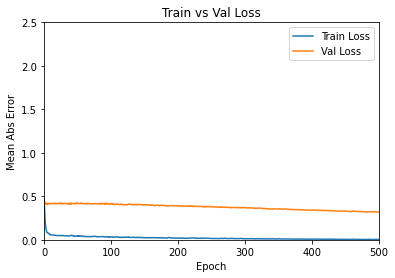

In [15]:
# Plot train and validation loss
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.title('Train vs Val Loss')
plt.legend()
plt.ylim([0, 2.5])
plt.xlim([0, 500])
plt.show()
fig.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_loss_1' + '.png', dpi=400, bbox_inches = "tight")


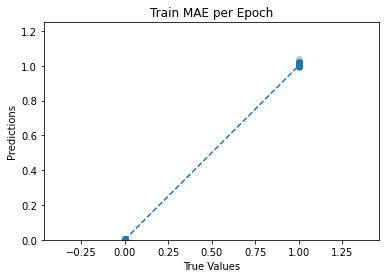

In [16]:
# Plot train MAE per epoch
plt.scatter(y_train, train_pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('Train MAE per Epoch')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' +activation1 + '_' + activation2 + '_' + 'true_vs_pred_train.png', bbox_inches = "tight")

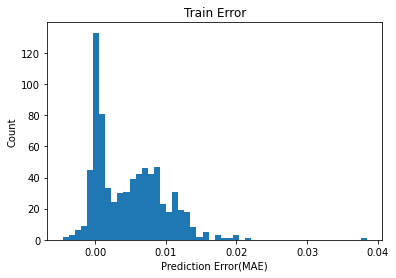

In [17]:
# plot train error
error = train_pred - y_train
plt.hist(error, bins = 50)
plt.title('Train Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_error.png', bbox_inches = "tight")

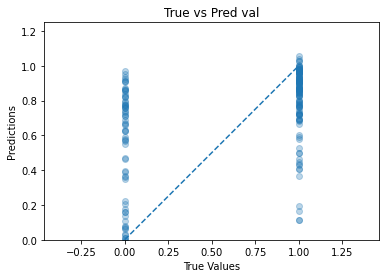

In [18]:
# plot true vs pred for val dataset
plt.scatter(y_val, pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred val')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_val.png', bbox_inches = "tight")

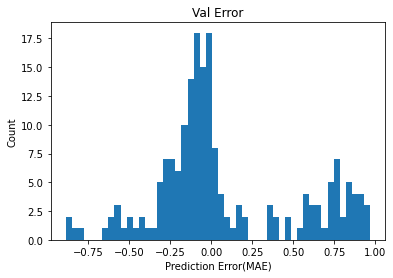

In [19]:
# plot val error 
error = pred.flatten() - y_val.flatten()
plt.hist(error, bins = 50)
plt.title('Val Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'val_error.png', bbox_inches = "tight")

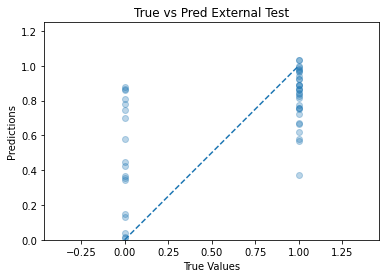

In [20]:
# plot true vs pred for ext test dataset
plt.scatter(y_test2.flatten(), pred_ext.flatten(), alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred External Test')
plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_external_test.png', bbox_inches = "tight")

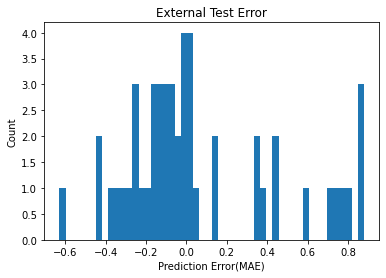

In [21]:
# plot ext test distribution
error = pred_ext.flatten() - y_test2.flatten()
plt.hist(error, bins = 50)
plt.title('External Test Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'external_test_error.png', bbox_inches = "tight")

In [22]:
# random probs for auc
r_probs = [0 for _ in range(len(y_val))]

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
#Random chance ROC
r_auc = roc_auc_score(y_val, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)

#val ROC
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)

#Train ROC
tr_fpr, tr_tpr, _ = roc_curve(y_train, train_pred)
tr_auc = roc_auc_score(y_train, train_pred)

# External Test ROC
ext_fpr, ext_tpr, _ = roc_curve(y_test2, pred_ext)
ext_auc = roc_auc_score(y_test2, pred_ext)

In [24]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Val Prediction: AUROC = %.3f' % (auc))
print('Train Prediction: AUROC = %.3f' % (tr_auc))
print('External Test Prediction: AUROC = %.3f' % (ext_auc))

Random (chance) Prediction: AUROC = 0.500
Val Prediction: AUROC = 0.778
Train Prediction: AUROC = 1.000
External Test Prediction: AUROC = 0.845


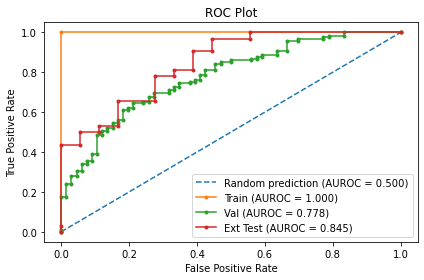

In [25]:
# AUC Plot
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(tr_fpr, tr_tpr, marker='.', label='Train (AUROC = %0.3f)' % tr_auc)
plt.plot(fpr, tpr, marker='.', label='Val (AUROC = %0.3f)' % auc)
plt.plot(ext_fpr, ext_tpr, marker='.', label='Ext Test (AUROC = %0.3f)' % ext_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc = 'lower right', prop={'size': 10}) 
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'ROC_Curve_1' + '.png', bbox_inches = "tight")

In [26]:
# Convert predictions to binary for confusion matrix
val_pred_int = np.where(pred<0.5, 0, 1)
train_pred_int = np.where(train_pred<0.5, 0, 1)
ext_test_pred_int = np.where(pred_ext<0.5, 0, 1)

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
val_conf = confusion_matrix(y_val, val_pred_int)
train_conf = confusion_matrix(y_train, train_pred_int)
ext_test_conf = confusion_matrix(y_test2, ext_test_pred_int)

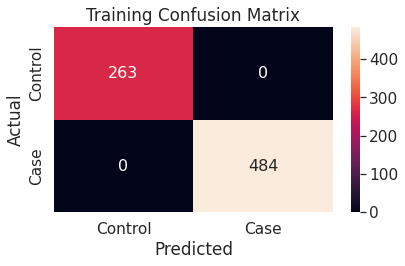

In [41]:
# Plot Confusion Matrices 
import seaborn as sns
df_cm = pd.DataFrame(train_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_train' + '.png', bbox_inches = "tight")

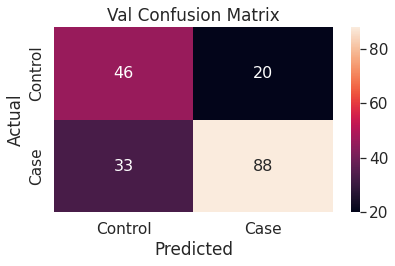

In [42]:
import seaborn as sns
df_cm = pd.DataFrame(val_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Val Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_val' + '.png', bbox_inches = "tight")

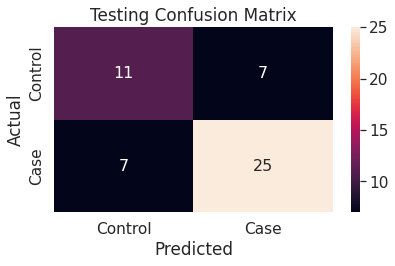

In [43]:
df_cm = pd.DataFrame(ext_test_conf, range(2), range(2))
df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_external_test' + '.png', bbox_inches = "tight")

In [44]:
# Define AUC metric function
def get_auc(val_auc, train_auc):
    auc_score = roc_auc_score(val_auc, train_auc)
    return auc_score

In [45]:
from mlxtend.evaluate import feature_importance_permutation

In [46]:
# feature importance permutation 
imp_vals, imp_all = feature_importance_permutation(
    predict_method = model.predict,
    X = x_test2,
    y = y_test2,
    metric =  get_auc,
    num_rounds = 1)

In [47]:
# sort the cpg islands from descending order of importance 
indices = np.argsort(imp_vals)[::-1]

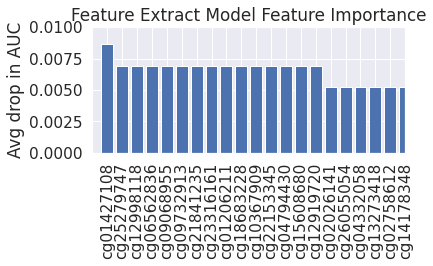

In [48]:
# plot top 20 cpg islands 
plt.figure()
plt.title("Feature Extract Model Feature Importance")
plt.ylabel('Avg drop in AUC')
plt.bar(range(x_train.shape[1]), imp_vals[indices])

plt.xticks(range(x_train.shape[1]), x_train_df.columns[indices], rotation=90)
plt.xlim([-1, 20])
plt.ylim([0, 0.01])

plt.tight_layout()
plt.savefig('Feature Importance.png')
plt.show()

In [49]:
# Get top 50 CPG islands
cpg_islands = x_train_df.columns[indices][:50]

In [50]:
# export top 50 cpg islands
with open("top_50_cpg_islands.txt","w") as f:
    for line in cpg_islands:
        f.write(line)
        f.write("\n")

In [51]:
cpg_islands_500 = x_train_df.columns[indices][:500]

In [52]:
with open("top_500_cpg_islands.txt","w") as f:
    for line in cpg_islands_500:
        f.write(line)
        f.write("\n")

In [53]:
# Get top 500 CPGs
top_500 = x_train_df.columns[indices][:500]

# Get top 500 CPG with attributes as df
top_500_df = x_train_df.loc[:,top_500]

# concatenate train, val and external test datasets 
df = pd.concat([meth, val, test2])

# subset the top 500 cpgs from the full dataset above 
top_500_df = df.loc[:,top_500]